Скачайте материалы к занятию. Проанализируйте ряды, сделайте их стационарными.

In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [10]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [12]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


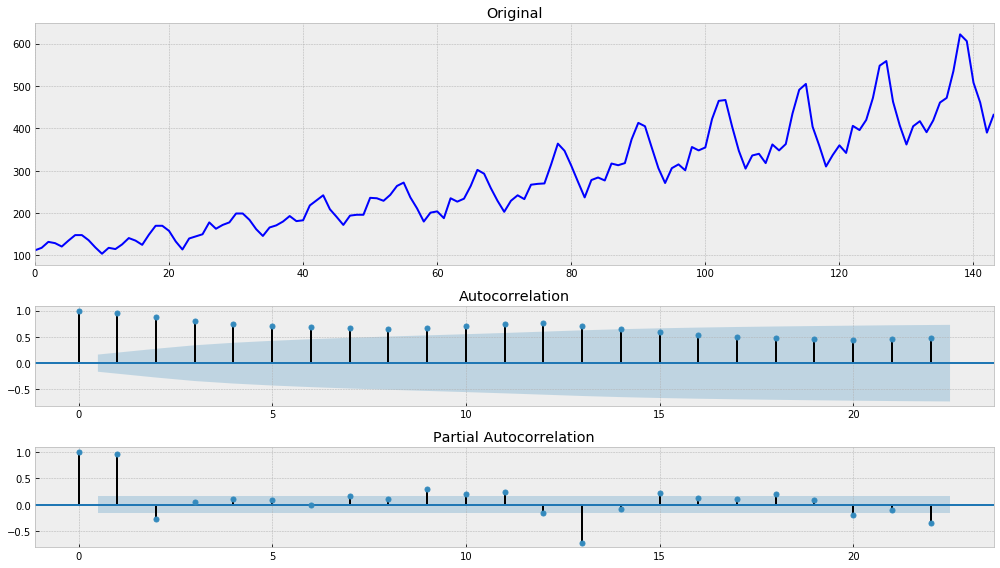

In [13]:
tsplot(airlines_passengers)

In [ ]:
#тут нужно учитывать и тренд и сезонность и уровень.

In [26]:
i = 0

In [27]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [28]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [29]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [30]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

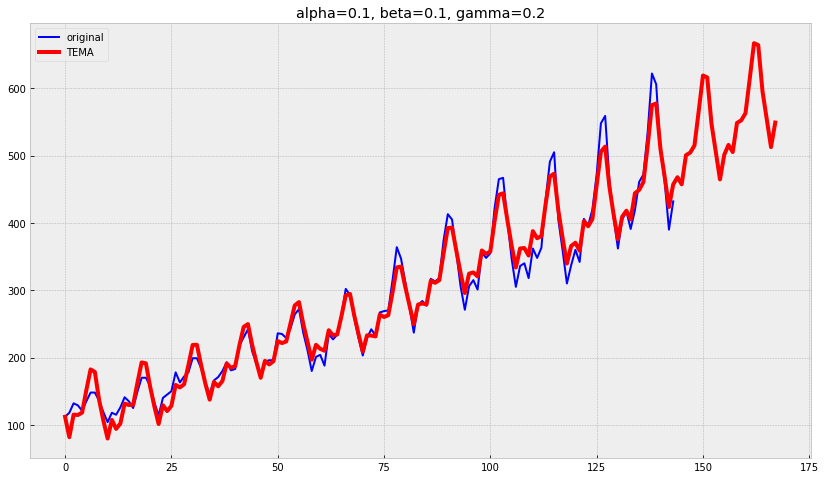

In [31]:
plot_tema(0.1, 0.1, 0.2)

In [ ]:
#Красота попробуем другие коэфф

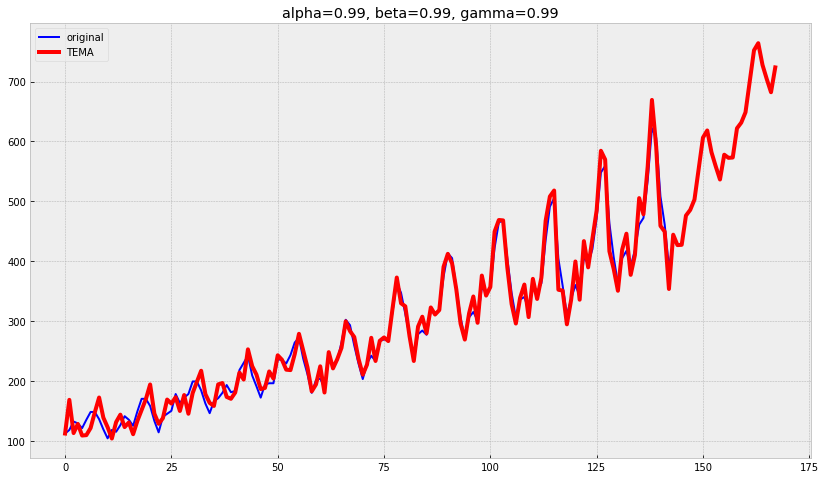

In [32]:
plot_tema(0.99, 0.99, 0.99)

In [ ]:
#сезонность ушла

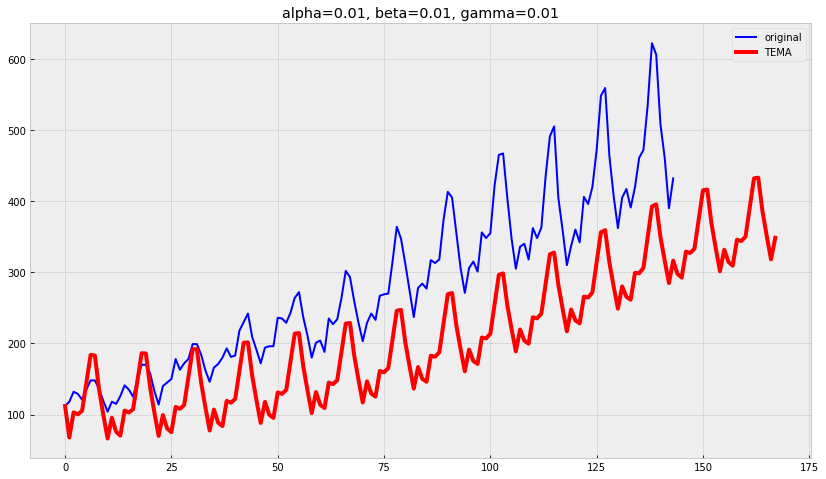

In [33]:
plot_tema(0.01, 0.01, 0.01)

In [34]:
#Большой сдвиг

In [36]:
airlines_passengers.count()

144

In [76]:
train, test, val = airlines_passengers[:60], airlines_passengers[60:100], airlines_passengers[100:]

In [77]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [78]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [79]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 431.296404474983
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3357.02261509,   -19.01322548,    10.3186494 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 328
      nit: 55
   status: 0
  success: True
        x: array([0.00257785, 0.88844607, 0.28445189])


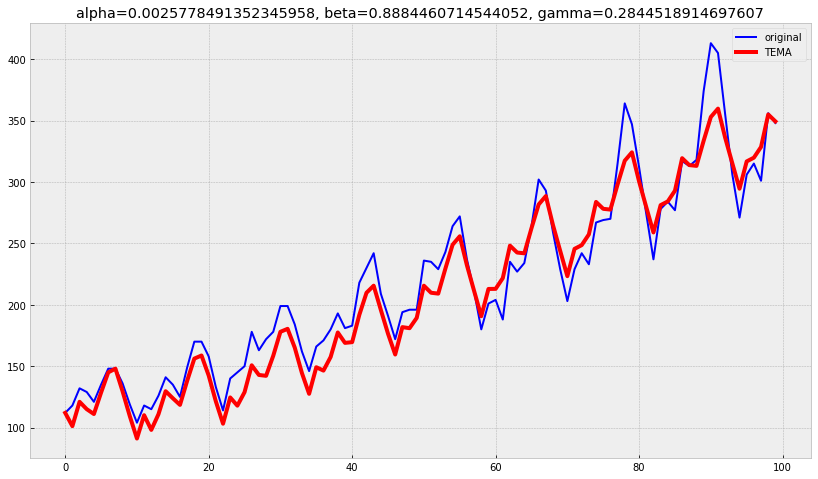

In [80]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=airlines_passengers[:100], n_preds=len(test))

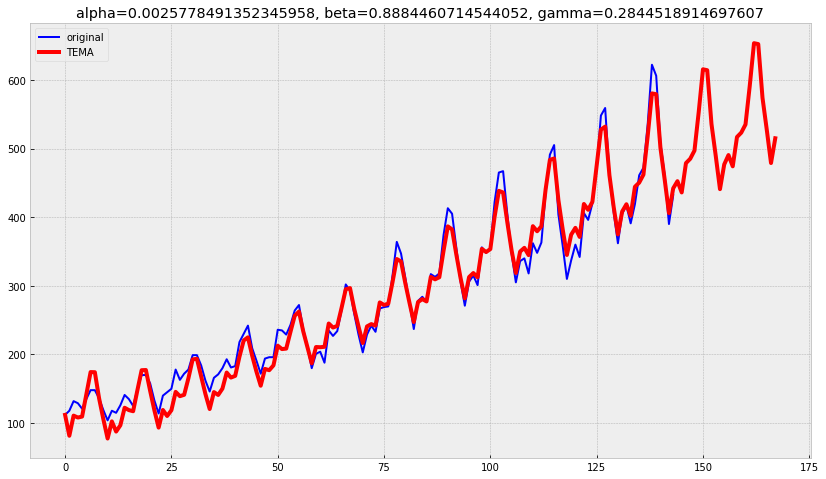

In [83]:
plot_tema(alpha_opt, beta_opt, gamma_opt)

In [84]:
#кэфы еще больше описывают динамику временного ряда. Мне нравится. проверим кросс валл

In [85]:
train, val = airlines_passengers[:60], airlines_passengers[60:]

In [86]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [87]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [88]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.5870017919712031
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.99218461e-05,  1.41220369e-05, -2.58681965e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 41
   status: 0
  success: True
        x: array([0.05128334, 0.48574393, 0.83701564])


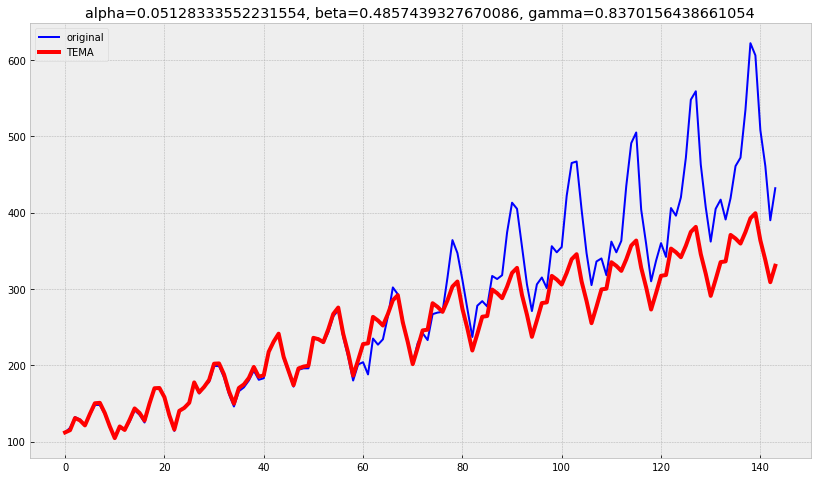

In [89]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=airlines_passengers, n_preds=len(val))

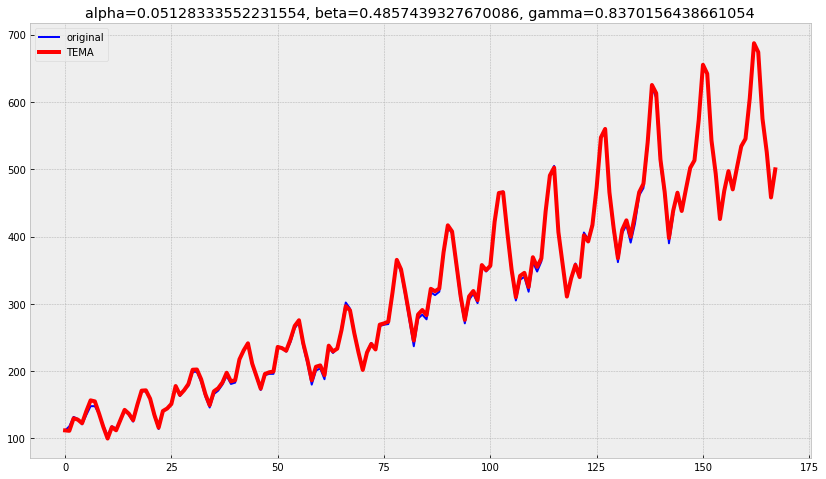

In [90]:
plot_tema(alpha_opt, beta_opt, gamma_opt)

In [91]:
#Эти кэфы начали даже еще лучше описывать ряд. Но что то меня смущает что визуально идут один к одному с фактом

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


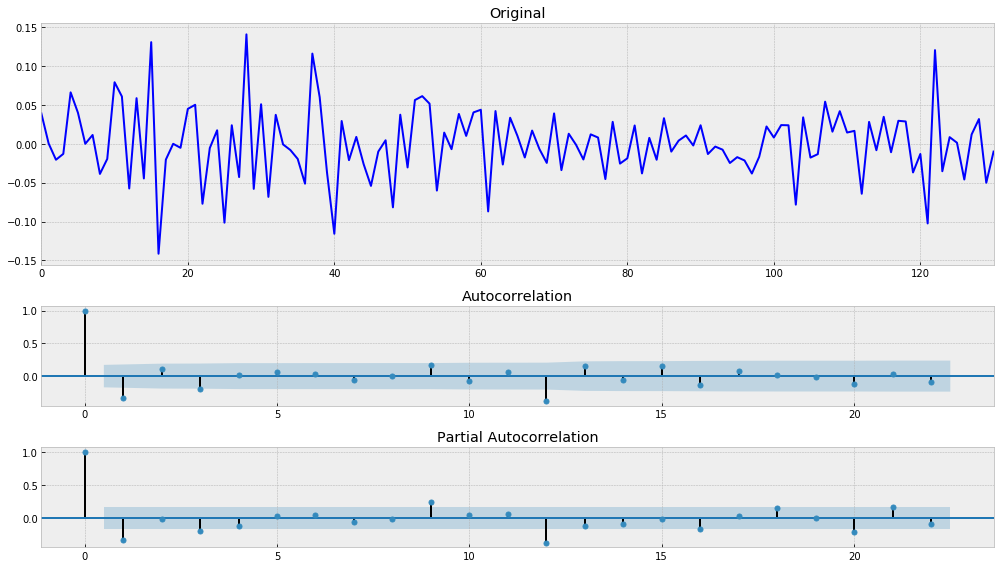

In [6]:
airlines_passengers_stat = boxcox(airlines_passengers,0)
airlines_passengers_stat = airlines_passengers_stat[1:] - airlines_passengers_stat[:-1]
airlines_passengers_stat = airlines_passengers_stat[12:] - airlines_passengers_stat[:-12]
tsplot(airlines_passengers_stat)

In [92]:
#ряд стационарным - посмотрим просто скользящую среднюю

In [93]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

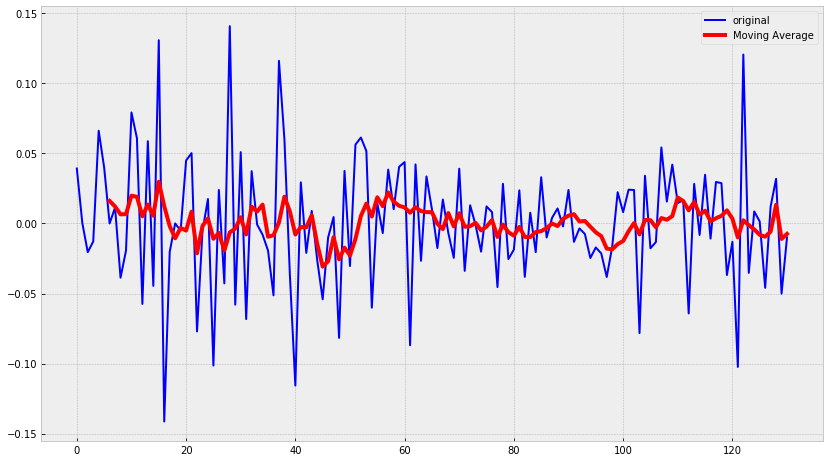

In [94]:
ser = moving_average(airlines_passengers_stat, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers_stat, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [95]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [100]:
series_pred = predict(pd.Series(airlines_passengers_stat), 7, 50)

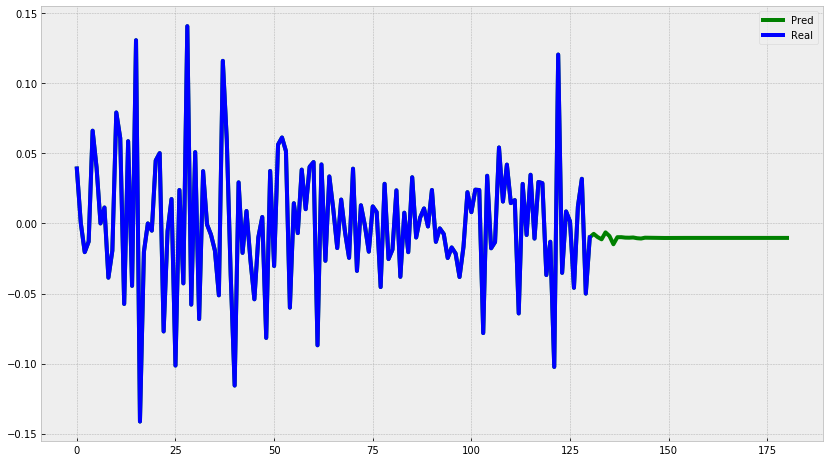

In [102]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(airlines_passengers_stat, color='blue', linewidth='4', label='Real')
    plt.legend()

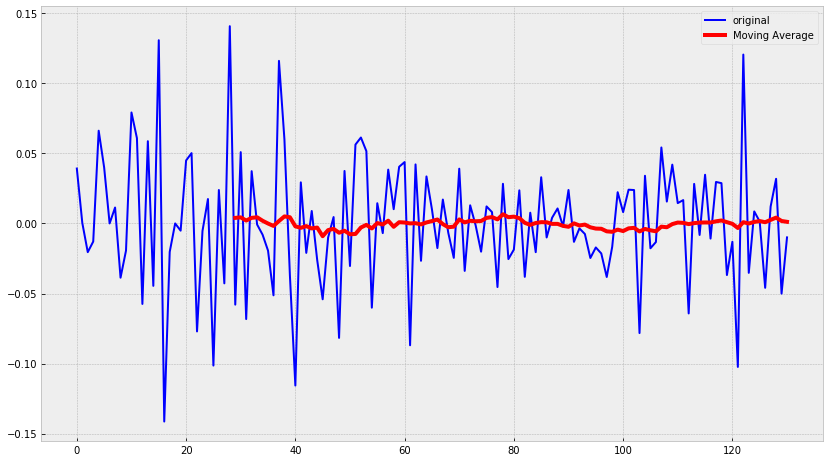

In [103]:
ser = moving_average(airlines_passengers_stat, 30)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers_stat, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [116]:
#https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [114]:
# AR example
from statsmodels.tsa.ar_model import AR

# contrived dataset
data = airlines_passengers
# fit model
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data)+100)
#print(yhat)


In [137]:
model_fit.k_ar

13

In [138]:
model_fit.params

const        5.148972
L1.Count     0.760839
L2.Count    -0.085279
L3.Count     0.044238
L4.Count    -0.041790
L5.Count     0.054281
L6.Count    -0.052773
L7.Count     0.033219
L8.Count    -0.099693
L9.Count     0.145556
L10.Count   -0.125891
L11.Count    0.143583
L12.Count    0.907057
L13.Count   -0.665976
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


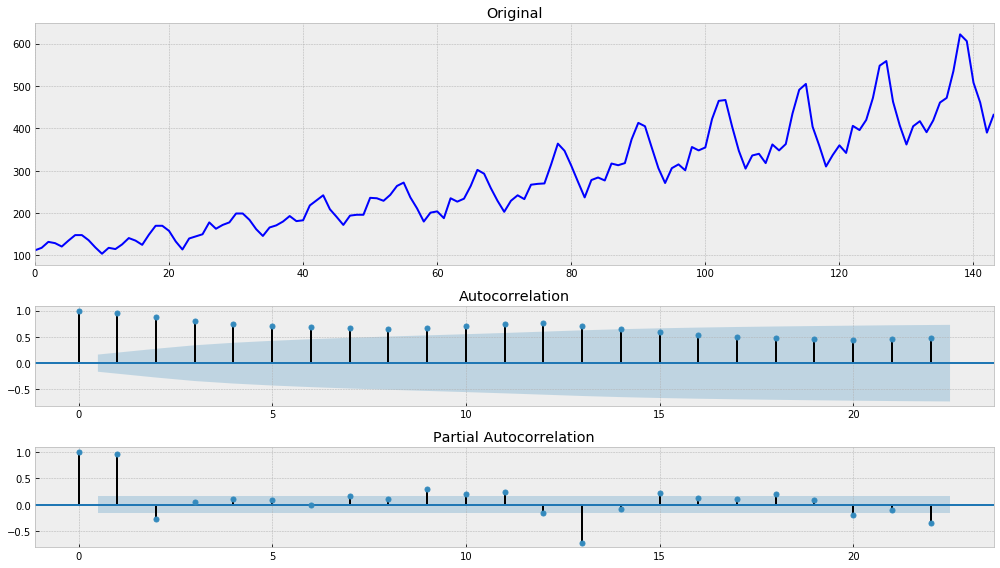

In [113]:
tsplot(airlines_passengers)

Results of Dickey-Fuller Test:
Test Statistic                 4.459847e+08
p-value                        1.000000e+00
#Lags Used                     1.300000e+01
Number of Observations Used    8.700000e+01
Critical Value (1%)           -3.507853e+00
Critical Value (5%)           -2.895382e+00
Critical Value (10%)          -2.584824e+00
dtype: float64


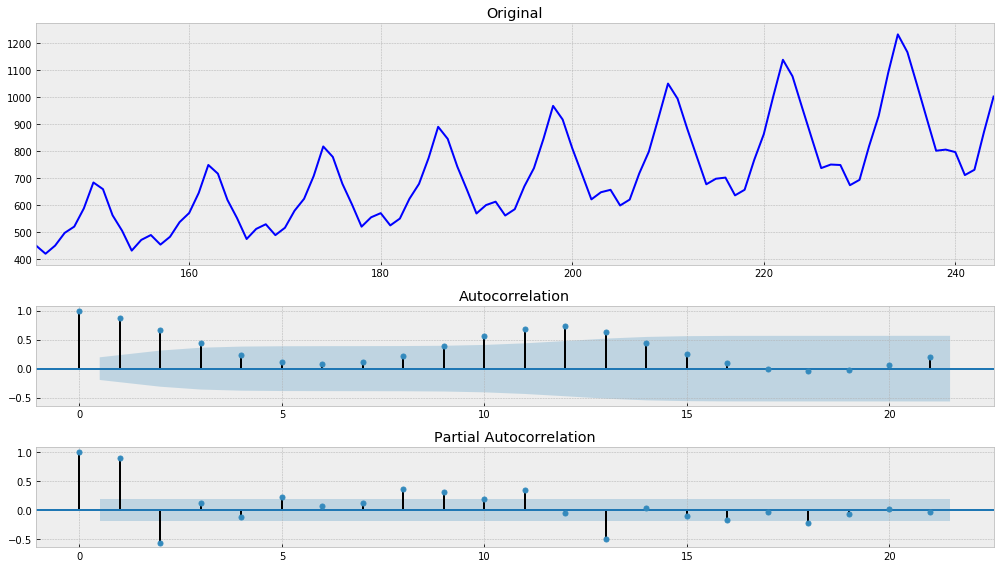

In [115]:
tsplot(yhat)

In [126]:
ttt = pd.concat([airlines_passengers, yhat])

Results of Dickey-Fuller Test:
Test Statistic                   3.143879
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


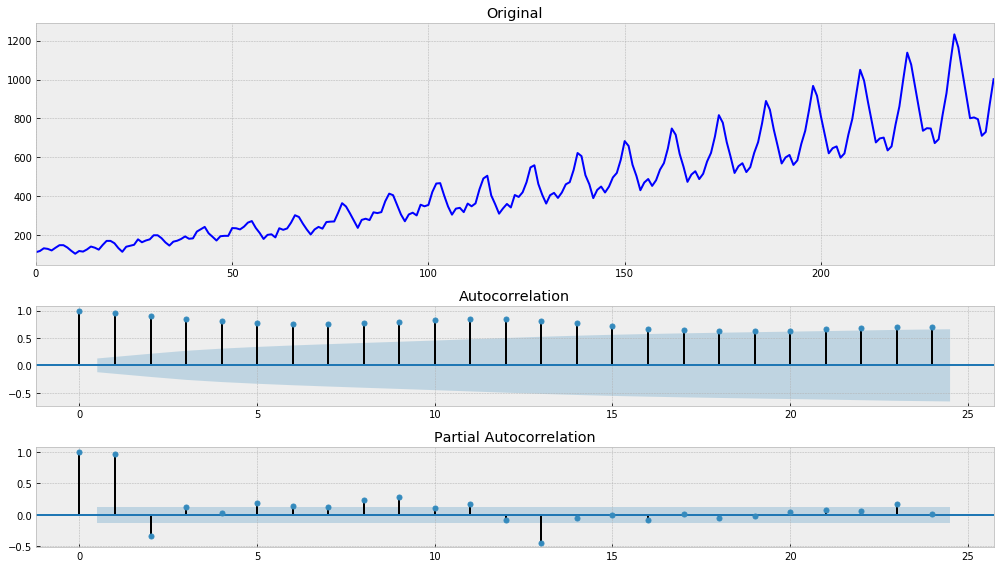

In [133]:
tsplot(ttt)
